## Comparing compiled vs interpreted language performance.

#### Ziad Arafat - 2023-03-05

The performance of compiled and interpreted languages has been a topic of interest in programming languages research for decades. While compiled languages are generally known for their faster runtime performance, interpreted languages offer advantages in terms of ease of use and portability. In this experiment, we aimed to explore the practical performance of compiled and interpreted languages in implementing Gaussian elimination with back substitution, a widely used numerical algorithm. We implemented the algorithm in Python and FORTRAN, and tested their runtime performance on matrices of varying size, with and without the use of numpy. The experiment provides insights into the practical trade-offs between compiled and interpreted languages in the context of numerical algorithms.

#### These commands will clean and compile our fortran program so its ready to execute

In [1]:
!pip install -r requirements.txt

In [2]:
!make clean
!make

rm -f *.o *.mod
gfortran -std=gnu -c mymodule.f90
gfortran -std=gnu -c gaussian_elimination.f90
gfortran mymodule.o gaussian_elimination.o -o gaussian_elimination
# gfortran -std=gnu -o gaussian_elimination gaussian_elimination.f90


### Python function to generate a random matrix of size nxn

In [3]:
import random

def generate_matrix_and_vector(n):
        """
        This function generates a random square matrix of size n x n.
        
        Args:
        n: the size of the square matrix
        
        Returns:
        a list of lists representing the random square matrix
        
        """
        min_value = -2000.0
        max_value = 2000.0
        
        matrix = []

        for row in range(n):
                next_row = []
                for column in range(n):
                        next_row.append(random.uniform(min_value, max_value))
                matrix.append(next_row)
        vector = [random.uniform(min_value, max_value) for number in range(n)]
        
        return matrix, vector

### Python function to measure our runtime

In [4]:
import time

def measure_time(func, *args, **kwargs):
    """
    This function measures the time it takes to run another function with a given set of arguments.
    
    Args:
    func: the function to be measured
    *args: the positional arguments for the function
    **kwargs: the keyword arguments for the function
    
    Returns:
    the runtime of the function in seconds
    
    """
    start_time = time.time()
    func(*args, **kwargs)
    end_time = time.time()
    runtime = end_time - start_time
    return runtime


### Python without numpy

In [5]:
def gaussian_elimination(matrix, vector):
    """
    This function performs Gaussian elimination with back substitution on a given square matrix A and vector b, 
    without partial pivoting or using numpy.
    
    Args:
    A: a square matrix of size n x n
    b: a vector of length n
    
    Returns:
    x: a vector of length n that represents the solution to the linear system Ax = b
    
    """
    n = len(matrix)
    
    # Forward elimination
    for i in range(n):
        # Check if the diagonal element is zero
        if matrix[i][i] == 0:
            raise ValueError('Diagonal element is zero, cannot proceed with Gaussian elimination')
        # Normalize the current row
        for j in range(i + 1, n):
            ratio = matrix[j][i] / matrix[i][i]
            for k in range(i, n):
                matrix[j][k] -= ratio * matrix[i][k]
            vector[j] -= ratio * vector[i]
    
    # Back substitution
    x = [0] * n
    for i in range(n - 1, -1, -1):
        x[i] = vector[i]
        for j in range(i + 1, n):
            x[i] -= matrix[i][j] * x[j]
        x[i] /= matrix[i][i]
    
    return x


### Python with numpy

In [6]:
import numpy as np
import scipy

def gaussian_elimination_lu(matrix, vector):
    """
    This function performs Gaussian elimination with back substitution using LU decomposition with partial pivoting.
    
    Args:
    n: the size of the square matrix
    matrix: the square matrix as a list of lists
    vector: the vector as a list
    
    Returns:
    the solution vector as a NumPy array
    
    """
    # Convert the matrix and vector to NumPy arrays
    

    # Perform LU decomposition with partial pivoting
    pivoted, L, U = scipy.linalg.lu(matrix)

    # Solve the system using back substitution
    y = np.linalg.solve(L, pivoted.dot(vector))
    x = np.linalg.solve(U, y)

    return x


### Python functions to run our fortran program

#### Function to generate the command line args

In [7]:
def generate_fortran_args(matrix, vector):
        """
        This function generates command line arguments for a Fortran program.

        Args:
        matrix: the square matrix as a list of lists
        vector: the vector as a list

        Returns:
        a list of command line arguments

        """
        # Create a new matrix with the vector appended as a new column
        new_matrix = [row + [vector[index]] for index, row in enumerate(matrix)]
        n = len(matrix)
        
        matrix_string = " ".join([str(x) for row in new_matrix for x in row])
        with open("matrix.txt", "w") as file:
                file.write(matrix_string)
        # Flatten the matrix into a list of arguments and start with dimensions
         
        args = [str(n), str(n + 1)] + ["matrix.txt"]

        return args


#### Function to execute the fortran command

In [8]:
import subprocess

def execute_fortran_program(args):
    """
    This function executes a local Fortran program with given command line arguments.
    
    Args:
    args: a list of command line arguments
    
    Returns:
    the output of the Fortran program
    
    """
    
    # Run the Fortran program with the given arguments using subprocess
#     print(args)
    output = subprocess.check_output(['./gaussian_elimination'] + args, universal_newlines=True)
    
    return output


#### Function to execute the fortran with the generated args and measure the runtime

In [10]:
# Parameters
sample_size = 5
input_sizes = (250, 500, 1000, 1500, 2000)
algorithms = ("fortran", "python no numpy", "python with numpy")

# Generate a dict to store the results
results = dict(zip(algorithms, 
              [dict(zip(input_sizes, 
                   [[] for item in input_sizes])) for _ in algorithms]))

"""
for each input size run 5 samples on each program
"""
for n_size in input_sizes:
        for sample in range(sample_size):
            
                # Fortran segment
                matrix, vector = generate_matrix_and_vector(n_size)
                fortran_args = generate_fortran_args(matrix, vector)
                print("Executing Fortran with", n_size, "number", sample+1)
                result_fortran = measure_time(execute_fortran_program,
                                              fortran_args)
                results["fortran"][n_size].append(result_fortran)
                
                # Python without numpy
                print("Executing python with", n_size, "number", sample+1)
                result_python = measure_time(gaussian_elimination, 
                                             matrix, vector)
                results["python no numpy"][n_size].append(result_python)
                
                
                # Python with numpy
                print("Executing numpy with", n_size, "number", sample+1)
                matrix_np = np.array(matrix, dtype=float)
                vector_np = np.array(vector, dtype=float)
                result_python_numpy = measure_time(gaussian_elimination_lu,
                                             matrix_np, vector_np)
                results["python with numpy"][n_size].append(result_python_numpy)    

Executing Fortran with 250 number 1
Executing python with 250 number 1
Executing numpy with 250 number 1
Executing Fortran with 250 number 2
Executing python with 250 number 2
Executing numpy with 250 number 2
Executing Fortran with 250 number 3
Executing python with 250 number 3
Executing numpy with 250 number 3
Executing Fortran with 250 number 4
Executing python with 250 number 4
Executing numpy with 250 number 4
Executing Fortran with 250 number 5
Executing python with 250 number 5
Executing numpy with 250 number 5
Executing Fortran with 500 number 1
Executing python with 500 number 1
Executing numpy with 500 number 1
Executing Fortran with 500 number 2
Executing python with 500 number 2
Executing numpy with 500 number 2
Executing Fortran with 500 number 3
Executing python with 500 number 3
Executing numpy with 500 number 3
Executing Fortran with 500 number 4
Executing python with 500 number 4
Executing numpy with 500 number 4
Executing Fortran with 500 number 5
Executing python wi

In [11]:
print(results)

{'fortran': {250: [0.03142690658569336, 0.03055882453918457, 0.03171944618225098, 0.031126976013183594, 0.03041243553161621], 500: [0.1489415168762207, 0.14835715293884277, 0.14467501640319824, 0.16194438934326172, 0.14330577850341797], 1000: [1.119581937789917, 1.0993216037750244, 1.092710018157959, 1.1344690322875977, 1.1082007884979248], 1500: [7.690381288528442, 7.5266945362091064, 7.437096357345581, 7.841766834259033, 7.600672721862793], 2000: [21.26940369606018, 21.320465803146362, 21.158955335617065, 21.314215183258057, 20.91407561302185]}, 'python no numpy': {250: [0.39046788215637207, 0.3968658447265625, 0.3935403823852539, 0.3991050720214844, 0.39130067825317383], 500: [3.359208822250366, 3.3581082820892334, 3.333726167678833, 3.314075231552124, 3.320261240005493], 1000: [27.365875005722046, 27.233760356903076, 27.45808434486389, 27.3409743309021, 27.382059812545776], 1500: [93.72291278839111, 92.54118609428406, 92.66156077384949, 92.51594376564026, 93.48898267745972], 2000: 

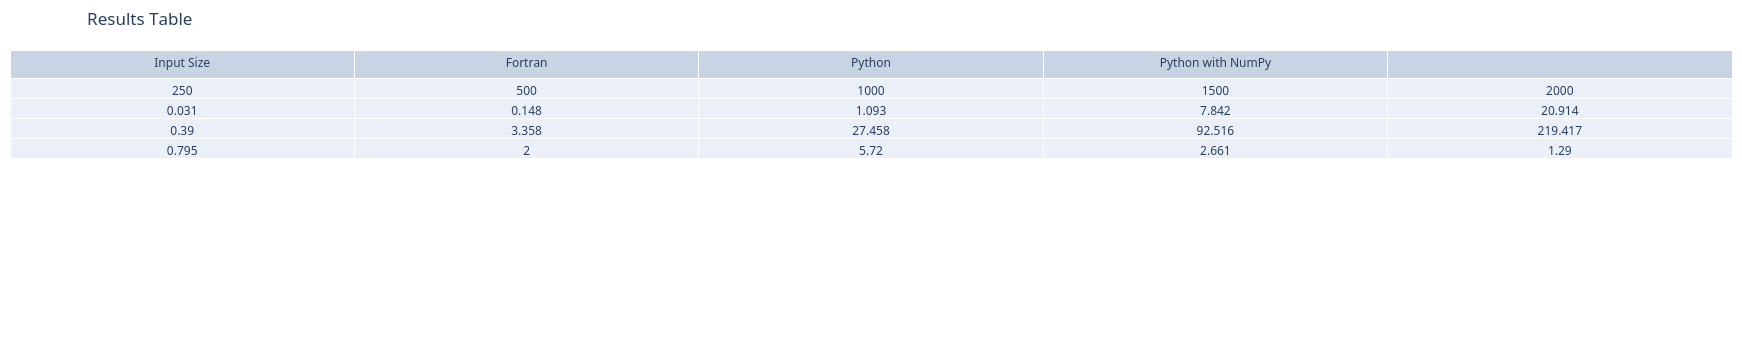

In [52]:
import plotly.graph_objs as go

def display_results_table(results_dict):
    # Extract the data from the results dict
    fortran_data = results_dict['fortran']
    python_data = results_dict['python no numpy']
    numpy_data = results_dict['python with numpy']

    # Set up the table header
    table_header = ['Input Size', 'Fortran', 'Python', 'Python with NumPy']

    # Set up the table rows
    table_rows = []
    for key, input_size in enumerate(sorted(fortran_data.keys())):
        row = list(map(lambda x: round(x, 3), [input_size, fortran_data[input_size][key], python_data[input_size][key], numpy_data[input_size][key]]))
        table_rows.append(row)

    # Create the Plotly table
    fig = go.Figure(data=[go.Table(header=dict(values=table_header),
                                   rows=dict(values=table_rows))])

    # Set the layout of the table
    fig.update_layout(title='Results Table',
                      height=len(fortran_data)*40,
                      width=600,
                      font=dict(size=12),
                      margin=dict(l=10, r=10, b=10, t=50))

    return fig

display_results_table(results).show()

In [39]:
import plotly.graph_objs as go

def plot_runtimes(data):
    fig = go.Figure()
    
    for program, program_data in data.items():
        x = sorted(program_data.keys())
        y = [sum(program_data[n])/len(program_data[n]) for n in x]
        fig.add_trace(go.Scatter(x=x, y=y, mode='lines+markers', name=program))
        
    fig.update_layout(
        title='Runtime vs Input Size',
        xaxis_title='Input Size',
        yaxis_title='Runtime (s)',
        legend_title='Program',
         xaxis=dict(
        title='Input size',
        type='category'  # Set the x-axis type to "category"
    ),
    yaxis=dict(
        title='Runtime (s)',
        scaleanchor="x",
        scaleratio=100,
        type="log"
    ))

    return fig


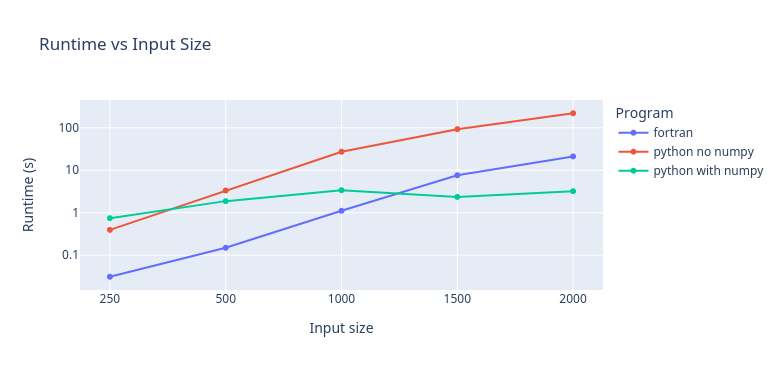

In [40]:
plot_runtimes(results).show()